# Notebook 기본 세팅

In [4]:
# Constant 선언

# 프로젝트 루트 디렉토리를 식별하기 위한 마커 파일 이름
ROOT_MARKER = "pyproject.toml"

# 한글 표시를 위한 나눔바른고딕 폰트 파일 이름
# matplotlib 의 font_manager 에 실제 폰트 파일의 위치를 넣어주어야 한다.
KOREAN_FONT_FILE = "NanumBarunGothic.ttf"

# matplotlib 에서는 font-family 의 이름으로 font 를 설정한다.
# 그래서 font 파일 그 자체가 아니라, 그 파일의 family 이름을 적어준다.
KOREAN_FONT_FAMILY = "NanumBarunGothic"

# 참고
# Font Family 와 Font File 의 차이는,
# Font Family 는 비슷한 디자인 특성을 공유하는 글꼴 그룹을 의미한다.
#
# 예를 들어 '나눔바른고딕' 폰트 패밀리는 일반(Regular), 굵게(BPold), 기울임(Italic) 등 여러 스타일을 포함할 수 있다.
# 반면, 폰트 파일(.ttf, .otf 등)은 이러한 폰트의 하나의 스타일이 저장된 실제 파일이다.
#
# 이 프로젝트에서는 폰트 용량을 줄이기 위해 일반(Regular) 인 NanumBarunGothic.ttf 만 사용한다.

In [5]:
# 프로젝트 root 를 sys.path 에 추가해서 import 구문을 사용하기 쉽게
from pathlib import Path


def find_project_root() -> Path:
    """
    pyproject.toml 파일을 기준으로 루트 디렉토리를 찾는다.
    :return: Path: 프로젝트 루트 디렉토리 경로
    """

    current_path = Path().resolve()

    while current_path != current_path.parent:
        if (current_path / ROOT_MARKER).exists():
            return current_path

        current_path = current_path.parent

    raise FileNotFoundError("프로젝트 루트 디렉토리를 찾을 수 없습니다.")


ROOT_DIR = find_project_root()

In [6]:
# matplotlib 의 한글 font 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt


FONTS_DATA_DIR = ROOT_DIR / "notebooks" / "fonts"


def setup_korean_font():
    font_path = FONTS_DATA_DIR / KOREAN_FONT_FILE
    fm.fontManager.addfont(font_path)

    # 폰트 설정
    plt.rcParams["font.family"] = KOREAN_FONT_FAMILY
    plt.rcParams["axes.unicode_minus"] = False


setup_korean_font()

# 데이터 API 연동 및 데이터 수집

## 기상청_지상(종관, ASOS) 일자료 조회서비스 API 사용

In [7]:
import requests
import pandas as pd
import time
import os
import math
import sys
import re

from tqdm import tqdm
from dotenv import load_dotenv
from datetime import datetime, timedelta

api 호출이 잘 되는지 확인을 위한 코드

In [ ]:
# WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")
# base_url = "http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList"
# common_params = {
#     "serviceKey": WEATHER_API_KEY,
#     "pageNo": "1",
#     "numOfRows": "10",
#     "dataType": "JSON",
#     "dataCd": "ASOS",
#     "dateCd": "DAY",
#     "startDt": "20250101",
#     "endDt": "20250131",
#     "stnIds": "93"
# }

# res = requests.get(base_url, params=common_params)

In [15]:
# response = res.json()
# response

2021년 1월 1일 ~ 어제까지의 데이터를 수집하는 코드
다만, 딜레이를 2초로 설정해놨어도 수집이 안되는 지점이 하나 발생하였고, 더 3초로 늘리니 다른 하나의 지점이 수집되지 않는 현상이 나타났다. 따라서 딜레이를 2초로 설정하여 데이터 수집하고, 수집 못한 지점에 대해서는 그 아래의 코드를 통해 재수집 및 데이터 재결합

In [9]:
def collect_data(start_date = "20210101", numofrows = "999"):
    # .env 파일 로드
    load_dotenv()

    # === 사용자 설정 ===
    WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")
    end_date = (datetime.today() - timedelta(days=1)).strftime("%Y%m%d")
    stn_ids = [
        90, 93, 95, 98, 99, 100, 101, 102, 104, 105, 106, 108, 112, 114, 115,
        119, 121, 127, 129, 130, 131, 133, 135, 136, 137, 138, 140, 143, 146,
        152, 155, 156, 159, 162, 165, 168, 169, 170, 172, 174, 177, 184, 185,
        188, 189, 192, 201, 202, 203, 211, 212, 216, 217, 221, 226, 232, 235,
        236, 238, 239, 243, 244, 245, 247, 248, 251, 252, 253, 254, 255, 257,
        258, 259, 260, 261, 262, 263, 264, 266, 268, 271, 272, 273, 276, 277,
        278, 279, 281, 283, 284, 285, 288, 289, 294, 295
    ]

    # === API 기본 정보 ===
    base_url = "http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList"
    common_params = {
        "serviceKey": WEATHER_API_KEY,
        "pageNo": "1",
        "numOfRows": numofrows,
        "dataType": "JSON",
        "dataCd": "ASOS",
        "dateCd": "DAY",
        "startDt": start_date,
        "endDt": end_date,
        "stnIds": stn_ids[0]
    }

    # 최대 pageNo 계산 (stn_ids[0] 하나로만)
    try:
        response = requests.get(base_url, params=common_params, timeout=20)
        response.raise_for_status()
        body = response.json()['response']['body']
        total_count = int(body['totalCount'])
        max_page_no = math.ceil(total_count / int(common_params["numOfRows"]))
        print(f"📄 총 페이지 수: {max_page_no}")
    except Exception as e:
        print(f"❌ 페이지 수 계산 실패: {e}")
        sys.exit("⛔ 프로그램 종료: 페이지 수 계산에 실패하여 데이터 수집을 미진행합니다.")

    # === 수집 시작 ===
    all_data = []

    for stn_id in tqdm(stn_ids, desc="Fetching weather data"):
        for page_no in range(1, max_page_no + 1):  # pageNo 1, 2, 3
            params = common_params.copy()
            params["stnIds"] = str(stn_id)
            params["pageNo"] = str(page_no)

            try:
                response = requests.get(base_url, params=params, timeout=20)
                response.raise_for_status()
                items = response.json()['response']['body']['items']['item']
                df = pd.DataFrame(items)
                df["stnId"] = stn_id
                all_data.append(df)
            except Exception as e:
                print(f"[{stn_id} - page {page_no}] 에러 발생: {e}")
                continue

            time.sleep(2)  # 서버 보호를 위한 딜레이

    # === 병합 및 저장 ===
    if all_data:
        result_df = pd.concat(all_data, ignore_index=True)

        # 시작년도와 종료년도 추출
        start_year = start_date[:4]
        end_year = end_date[:4]

        result_df.to_csv(f"../src/data/raw_weather_all_stations_{start_year}_{end_year}.csv", index=False)
        print(f"✅ 데이터 저장 완료: raw_weather_all_stations_{start_year}_{end_year}.csv")
    else:
        print("❌ 저장할 데이터가 없습니다.")


In [10]:
collect_data()

📄 총 페이지 수: 2


Fetching weather data:  13%|█▎        | 12/95 [01:49<12:40,  9.17s/it]

[112 - page 1] 에러 발생: Expecting value: line 1 column 1 (char 0)


Fetching weather data:  15%|█▍        | 14/95 [02:16<14:53, 11.03s/it]

[115 - page 1] 에러 발생: HTTPConnectionPool(host='apis.data.go.kr', port=80): Read timed out. (read timeout=20)


Fetching weather data:  16%|█▌        | 15/95 [02:43<21:04, 15.81s/it]

[115 - page 2] 에러 발생: Expecting value: line 1 column 1 (char 0)


Fetching weather data:  80%|████████  | 76/95 [12:29<04:04, 12.85s/it]

[263 - page 1] 에러 발생: Expecting value: line 1 column 1 (char 0)


Fetching weather data:  81%|████████  | 77/95 [13:00<05:27, 18.21s/it]

[263 - page 2] 에러 발생: HTTPConnectionPool(host='apis.data.go.kr', port=80): Read timed out. (read timeout=20)


Fetching weather data: 100%|██████████| 95/95 [15:42<00:00,  9.92s/it]


✅ 데이터 저장 완료: raw_weather_all_stations_2021_2025.csv


특정 지점의 데이터만 수집하여 결합하는 코드

In [12]:
def collect_specific_station_data(stn_ids, start_date = "20210101", numofrows = "999"):
    # .env 파일 로드
    load_dotenv()
    
    # === 사용자 설정 ===
    WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")
    end_date = (datetime.today() - timedelta(days=1)).strftime("%Y%m%d")

    # === API 기본 정보 ===
    base_url = "http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList"
    common_params = {
        "serviceKey": WEATHER_API_KEY,
        "pageNo": "1",
        "numOfRows": numofrows,
        "dataType": "JSON",
        "dataCd": "ASOS",
        "dateCd": "DAY",
        "startDt": start_date,
        "endDt": end_date,
        "stnIds": stn_ids[0]
    }

    # 최대 pageNo 계산 (stn_ids[0] 하나로만)
    try:
        response = requests.get(base_url, params=common_params, timeout=20)
        response.raise_for_status()
        body = response.json()['response']['body']
        total_count = int(body['totalCount'])
        max_page_no = math.ceil(total_count / int(common_params["numOfRows"]))
        print(f"📄 총 페이지 수: {max_page_no}")
    except Exception as e:
        print(f"❌ 페이지 수 계산 실패: {e}")
        sys.exit("⛔ 프로그램 종료: 페이지 수 계산에 실패하여 데이터 수집을 미진행합니다.")

    # === 수집 시작 ===
    all_data = []

    for stn_id in tqdm(stn_ids, desc="Fetching weather data"):
        for page_no in range(1, max_page_no + 1):  # pageNo 1, 2, 3
            params = common_params.copy()
            params["stnIds"] = str(stn_id)
            params["pageNo"] = str(page_no)

            try:
                response = requests.get(base_url, params=params, timeout=20)
                response.raise_for_status()
                items = response.json()['response']['body']['items']['item']
                df = pd.DataFrame(items)
                df["stnId"] = stn_id
                all_data.append(df)
            except Exception as e:
                print(f"[{stn_id} - page {page_no}] 에러 발생: {e}")
                continue

            time.sleep(2)  # 서버 보호를 위한 딜레이

    # === 병합 및 저장 ===
    if all_data:
        result_df = pd.concat(all_data, ignore_index=True)

        # 시작년도와 종료년도 추출
        start_year = start_date[:4]
        end_year = end_date[:4]

        result_df.to_csv(f"../src/data/raw_weather_specific_stations_{start_year}_{end_year}.csv", index=False)
        print(f"✅ 데이터 저장 완료: raw_weather_specific_stations_{start_year}_{end_year}.csv")
    else:
        print("❌ 저장할 데이터가 없습니다.")


In [13]:
collect_specific_station_data([112, 115, 263])

📄 총 페이지 수: 2


Fetching weather data: 100%|██████████| 3/3 [00:28<00:00,  9.56s/it]

✅ 데이터 저장 완료: raw_weather_specific_stations_2021_2025.csv


In [17]:
def concat_collected_data(
    stn_ids,
    all_data_path="../src/data/raw_weather_all_stations_2021_2025.csv",
    specific_station_data_path="../src/data/raw_weather_specific_stations_2021_2025.csv"):
    
    df_all = pd.read_csv(all_data_path)
    df_new = pd.read_csv(specific_station_data_path)

    # 기존 데이터 중 해당 지점들 제거
    df_all_filtered = df_all[~df_all["stnId"].isin(stn_ids)]

    # 병합
    df_combined = pd.concat([df_all_filtered, df_new], ignore_index=True)
    df_combined.sort_values(by=["stnId", "tm"], inplace=True)  # 정렬(optional)
    df_combined.to_csv(all_data_path, index=False)
    print("✅ 전체 데이터 갱신 완료")

    # 기존 임시 파일 제거
    if os.path.exists(specific_station_data_path):
        os.remove(specific_station_data_path)
        print(f"{specific_station_data_path} 삭제 완료")
    else:
        print(f"{specific_station_data_path} 파일이 존재하지 않습니다.")


In [18]:
concat_collected_data([112, 115, 263])

C:\Users\Pyeon\AppData\Local\Temp\ipykernel_17016\3820067154.py:6: DtypeWarning: Columns (60) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(all_data_path)


✅ 전체 데이터 갱신 완료
../src/data/raw_weather_specific_stations_2021_2025.csv 삭제 완료


# 변수 선택

In [21]:
def specific_features_data(selected_columns = [
    "stnId", "stnNm", "tm",
    "avgTa", "minTa", "maxTa",
    "sumRn", "hr1MaxRn", "mi10MaxRn",
    "avgWs", "maxWs", "maxInsWs"], 
    data_path = "../src/data/raw_weather_all_stations_2021_2025.csv"):
    
    # 기존 데이터셋 로드
    df = pd.read_csv(data_path)

    # 필요한 컬럼만 필터링
    df_filtered = df[selected_columns]

    # 정규표현식으로 4자리 숫자(연도) 2개 추출
    years = re.findall(r'\d{4}', data_path)

    # 변수에 할당
    start_year, end_year = map(int, years[:2])

    # 결과 확인 또는 저장
    print(df_filtered.head())
    df_filtered.to_csv(f"../src/data/raw_weather_all_stations_{start_year}_{end_year}_selected_features.csv", index=False)


In [22]:
specific_features_data()

C:\Users\Pyeon\AppData\Local\Temp\ipykernel_17016\3439689097.py:9: DtypeWarning: Columns (60) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


   stnId stnNm          tm  avgTa  minTa  maxTa  sumRn  hr1MaxRn  mi10MaxRn  \
0     90    속초  2021-01-01   -2.9   -7.7    1.2    NaN       NaN        NaN   
1     90    속초  2021-01-02   -2.5   -6.3    1.5    NaN       NaN        NaN   
2     90    속초  2021-01-03   -2.5   -5.8    0.7    NaN       NaN        NaN   
3     90    속초  2021-01-04   -0.9   -4.2    3.2    NaN       NaN        NaN   
4     90    속초  2021-01-05   -3.2   -7.3    0.1    NaN       NaN        NaN   

   avgWs  maxWs  maxInsWs  
0    2.2    5.2       9.8  
1    2.3    5.0       8.7  
2    3.6    7.3      12.5  
3    2.7    5.5       8.7  
4    2.5    5.7      12.4  


# 데이터 분석

In [11]:
df = pd.read_csv("../src/data/raw_weather_all_stations_2021_2025_selected_features.csv")

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152750 entries, 0 to 152749
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   stnId      152750 non-null  int64  
 1   stnNm      152750 non-null  object 
 2   tm         152750 non-null  object 
 3   avgTa      152523 non-null  float64
 4   minTa      152645 non-null  float64
 5   maxTa      152646 non-null  float64
 6   sumRn      59193 non-null   float64
 7   hr1MaxRn   37030 non-null   float64
 8   mi10MaxRn  37061 non-null   float64
 9   avgWs      152466 non-null  float64
 10  maxWs      152502 non-null  float64
 11  maxInsWs   152502 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 14.0+ MB


In [15]:
# avgWs, maxWs, maxInsWs 중 하나라도 결측치가 있는 행 필터링
null_wind_df = df[df[['avgTa']].isnull().any(axis=1)]

# 결과 확인
print(null_wind_df)

        stnId stnNm          tm  avgTa  minTa  maxTa  sumRn  hr1MaxRn  \
997        90    속초  2023-09-25    NaN   16.9   21.7    1.3       1.2   
1080       90    속초  2023-12-17    NaN   -8.5   -4.9    0.0       NaN   
1096       90    속초  2024-01-02    NaN    1.1    7.3    0.0       NaN   
1190       90    속초  2024-04-05    NaN    6.9   14.3    NaN       NaN   
2190       93   북춘천  2022-08-05    NaN   24.3   32.5    0.0       0.0   
...       ...   ...         ...    ...    ...    ...    ...       ...   
144751    284    거창  2025-04-10    NaN    NaN    NaN    NaN       NaN   
144752    284    거창  2025-04-11    NaN   10.5   25.1    NaN       NaN   
147385    288    밀양  2023-09-04    NaN    NaN    NaN    NaN       NaN   
151740    295    남해  2022-05-20    NaN    NaN    NaN    NaN       NaN   
152491    295    남해  2024-06-09    NaN   18.7   27.2    0.6       0.3   

        mi10MaxRn  avgWs  maxWs  maxInsWs  
997           0.5    1.2    2.2       3.4  
1080          NaN    1.7    3.5    

In [13]:
# avgWs, maxWs, maxInsWs 중 하나라도 결측치가 있는 행 필터링
null_wind_df = df[df[['maxWs']].isnull().any(axis=1)]

# 결과 확인
print(null_wind_df)

        stnId stnNm          tm  avgTa  minTa  maxTa  sumRn  hr1MaxRn  \
118        90    속초  2021-04-29   11.8    9.7   16.7    3.8       2.7   
947        90    속초  2023-08-06   27.0   25.4   30.0   55.0      37.4   
948        90    속초  2023-08-07   23.8   21.6   26.1   67.3      47.7   
949        90    속초  2023-08-08   22.8   21.2   24.3    0.4       0.4   
9173      100   대관령  2024-02-03   -3.5   -6.4   -0.7    NaN       NaN   
...       ...   ...         ...    ...    ...    ...    ...       ...   
152707    295    남해  2025-01-11   -0.4   -5.0    4.8    NaN       NaN   
152708    295    남해  2025-01-12    1.4   -2.4    5.1    NaN       NaN   
152709    295    남해  2025-01-13    2.2   -2.4    7.5    NaN       NaN   
152710    295    남해  2025-01-14    5.9   -0.6   11.6    NaN       NaN   
152797    295    남해  2025-04-11   15.2    8.9   23.0    NaN       NaN   

        mi10MaxRn  avgWs  maxWs  maxInsWs  
118           1.4    1.3    NaN       6.3  
947          14.5    NaN    NaN    

In [14]:
# avgWs, maxWs, maxInsWs 중 하나라도 결측치가 있는 행 필터링
null_wind_df = df[df[['maxInsWs']].isnull().any(axis=1)]

# 결과 확인
print(null_wind_df)

        stnId stnNm          tm  avgTa  minTa  maxTa  sumRn  hr1MaxRn  \
947        90    속초  2023-08-06   27.0   25.4   30.0   55.0      37.4   
948        90    속초  2023-08-07   23.8   21.6   26.1   67.3      47.7   
949        90    속초  2023-08-08   22.8   21.2   24.3    0.4       0.4   
9173      100   대관령  2024-02-03   -3.5   -6.4   -0.7    NaN       NaN   
9174      100   대관령  2024-02-04   -2.5   -3.3   -1.5    0.0       NaN   
...       ...   ...         ...    ...    ...    ...    ...       ...   
152707    295    남해  2025-01-11   -0.4   -5.0    4.8    NaN       NaN   
152708    295    남해  2025-01-12    1.4   -2.4    5.1    NaN       NaN   
152709    295    남해  2025-01-13    2.2   -2.4    7.5    NaN       NaN   
152710    295    남해  2025-01-14    5.9   -0.6   11.6    NaN       NaN   
152797    295    남해  2025-04-11   15.2    8.9   23.0    NaN       NaN   

        mi10MaxRn  avgWs  maxWs  maxInsWs  
947          14.5    NaN    NaN       NaN  
948          15.5    NaN    NaN    

In [25]:
# 결측치가 있는 주요 변수 리스트
missing_cols = ['avgTa', 'minTa', 'maxTa', 'sumRn', 'hr1MaxRn', 'mi10MaxRn', 'avgWs', 'maxWs', 'maxInsWs']

# 결측 여부를 이진 변수로 바꾸고, 다른 변수와 상관관계 계산
for col in missing_cols:
    print(f"📌 결측 변수: {col}")
    
    # 결측 여부 시리즈 생성 (결측: 1, 비결측: 0)
    null_flag = df[col].isnull().astype(int)
    
    # 수치형 변수만 필터링
    numeric_cols = df.select_dtypes(include='number').columns.drop(col)
    
    # 결측 여부와 수치형 변수들 간의 상관계수 계산
    corr_result = df[numeric_cols].apply(lambda x: null_flag.corr(x))
    
    # 절대값 기준 정렬
    print(corr_result.abs().sort_values(ascending=False).head(10))
    print("-" * 50)


📌 결측 변수: avgTa
hr1MaxRn     0.018519
mi10MaxRn    0.017477
stnId        0.008529
sumRn        0.008076
minTa        0.006084
maxTa        0.001975
maxWs        0.001431
avgWs        0.001089
maxInsWs     0.000725
dtype: float64
--------------------------------------------------
📌 결측 변수: minTa
mi10MaxRn    0.010153
stnId        0.009505
hr1MaxRn     0.009259
sumRn        0.008822
avgTa        0.004545
maxTa        0.003292
avgWs        0.002587
maxInsWs     0.001353
maxWs        0.000349
dtype: float64
--------------------------------------------------
📌 결측 변수: maxTa
stnId        0.008947
mi10MaxRn    0.005293
hr1MaxRn     0.004565
minTa        0.002583
avgWs        0.002012
sumRn        0.001023
maxInsWs     0.000472
avgTa        0.000374
maxWs        0.000128
dtype: float64
--------------------------------------------------
📌 결측 변수: sumRn
minTa        0.209803
maxInsWs     0.146078
avgTa        0.127202
maxWs        0.108542
avgWs        0.087689
maxTa        0.025033
stnId        0.0

상관관계 파악 결과

- 강수량 변수들은 sumRn의 경우 minTa와 0.21, hr1MaxRn과 mi10MaxRn의 경우 0.49의 상관관계를 가짐. 이를 참고하여 변수간의 관계를 통한 보간을 진행하거나, 그냥 0으로 설정 진행 방향 고려 중
- 다른 변수들의 경우 나머지 변수들과 연관이 없다시피하기에, 해당 변수의 결측치 날짜 이전/다음 날짜 기온 평균으로 보간 진행 방향 고려 중

코드 목적
- 대표 지점 2곳 (예: 서울 108, 제주 184)

- 9개 변수 각각에 대해

- 2021~2025년 데이터를 연도별로 색깔을 달리하여 하나의 선 그래프로 시각화

- 결측치는 자동으로 선이 끊기도록 처리

- 각 변수 × 각 지점 = 총 18개 그래프 생성

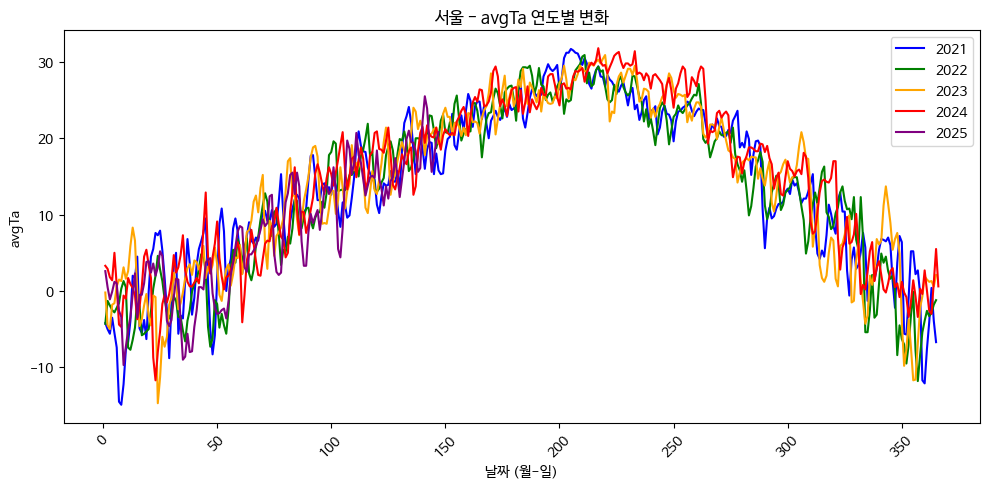

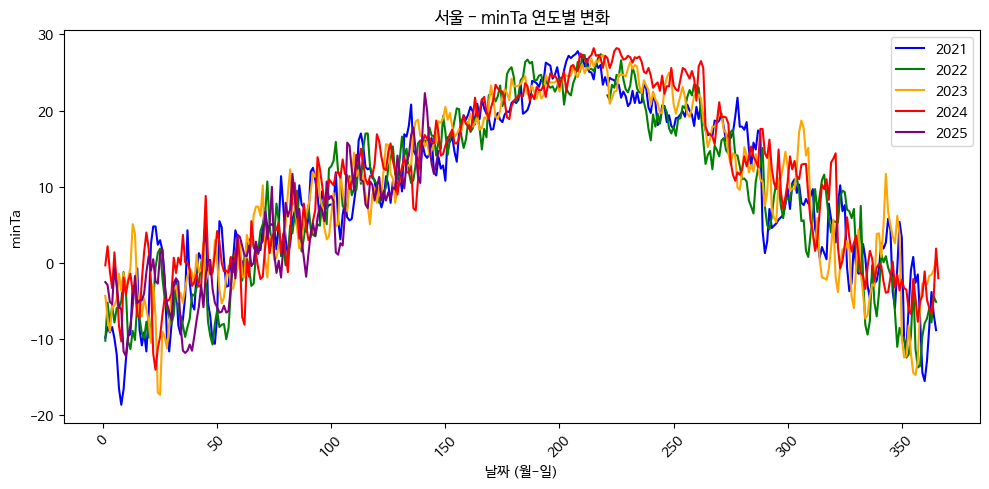

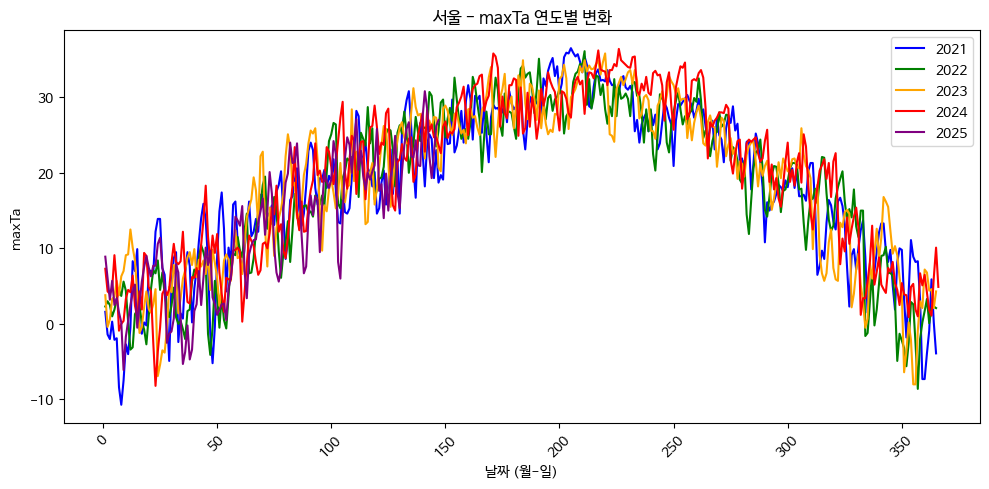

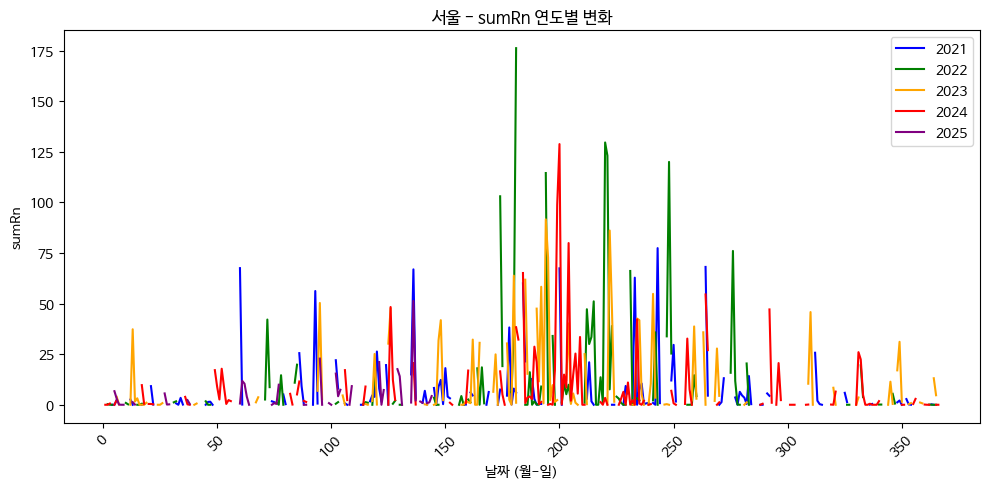

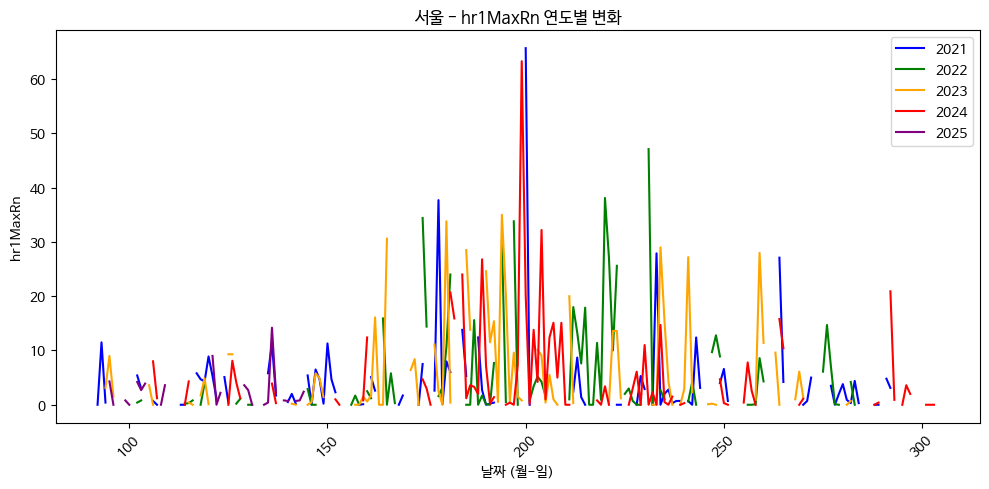

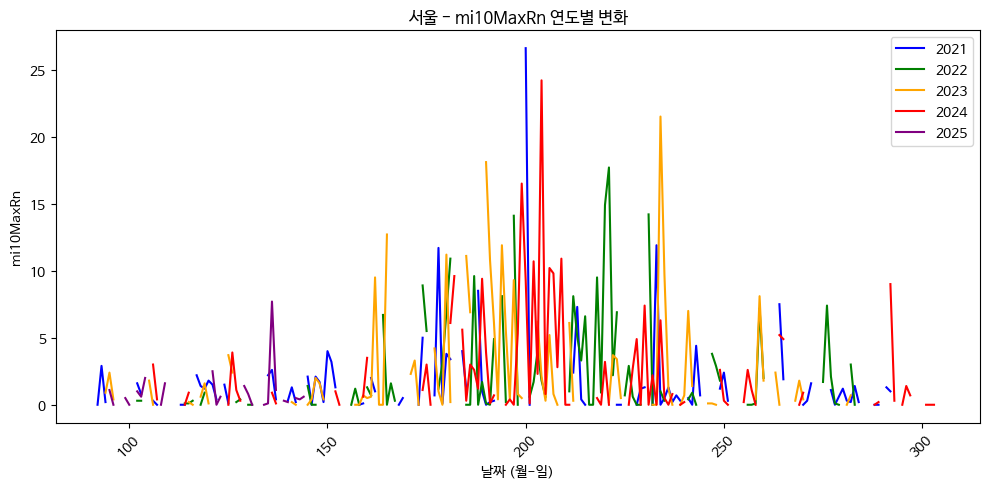

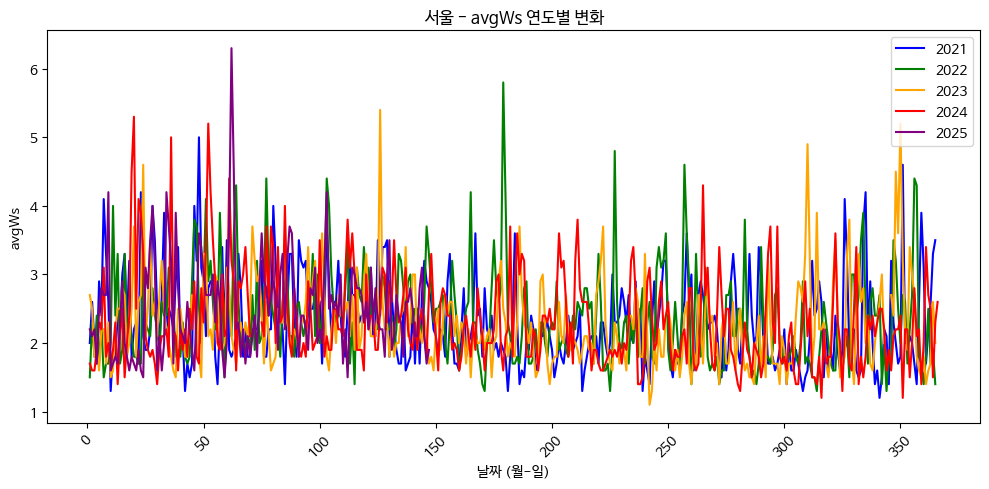

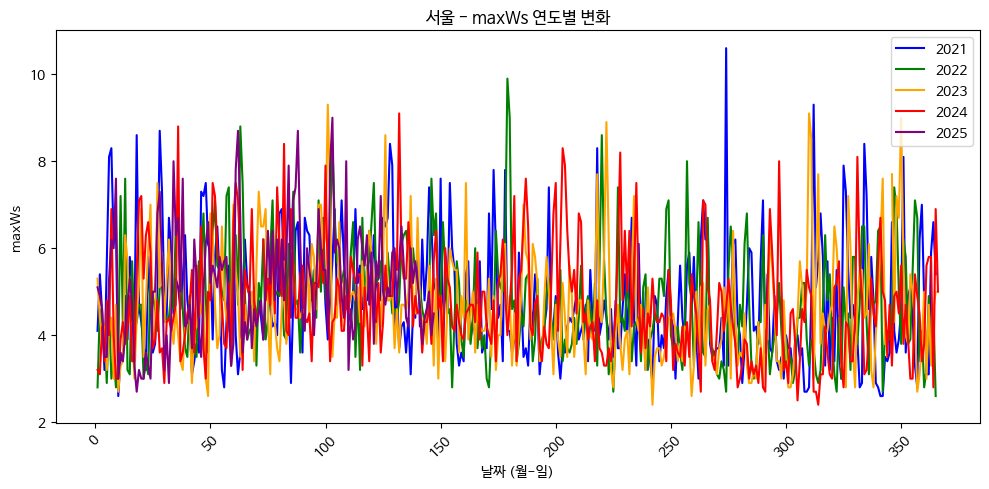

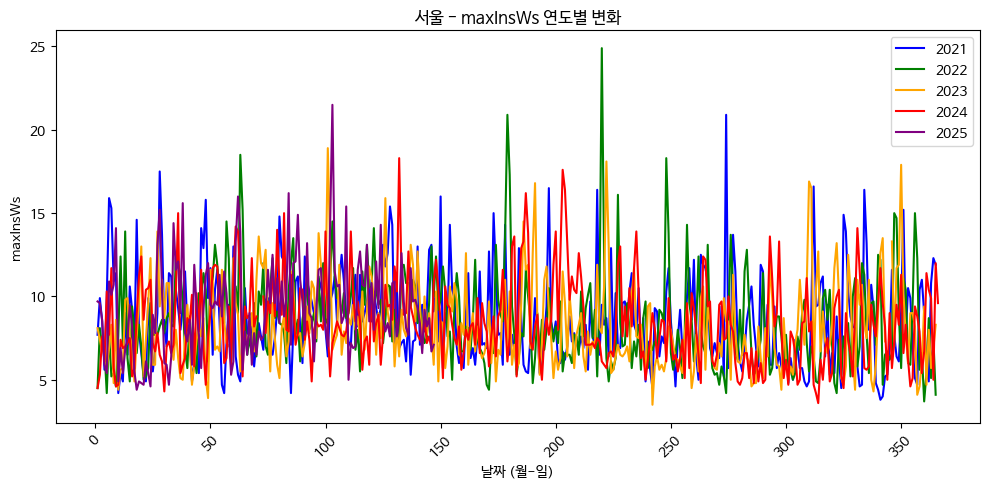

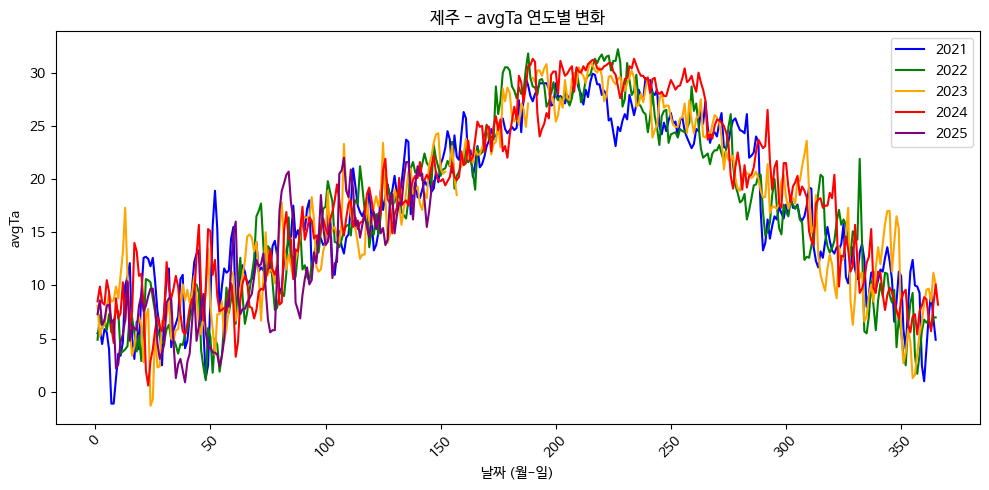

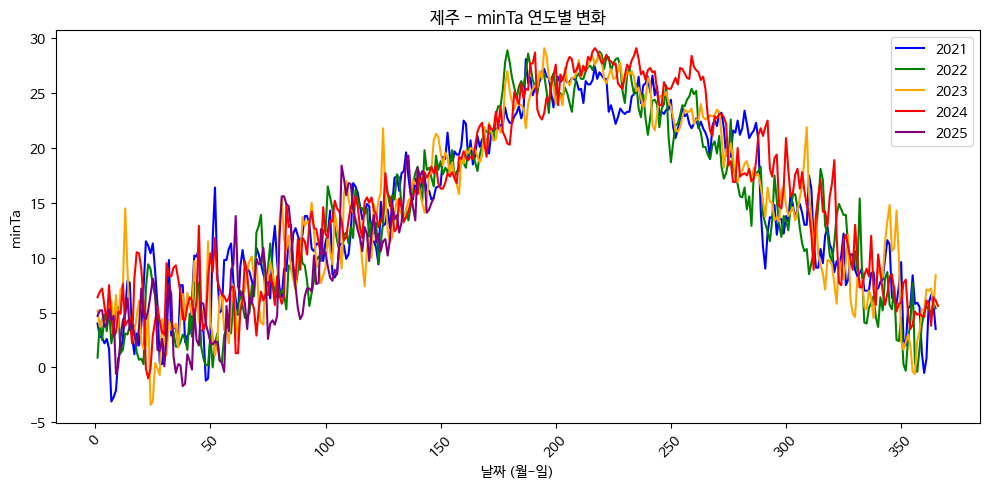

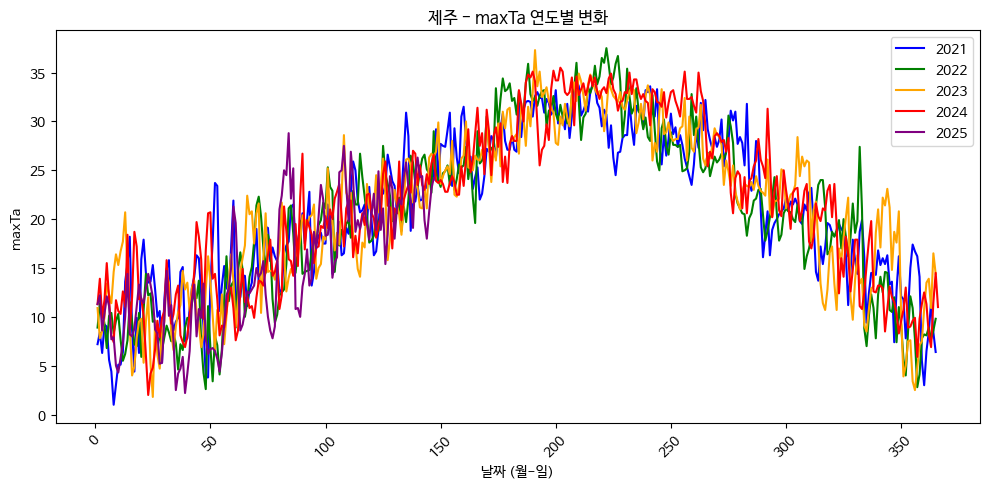

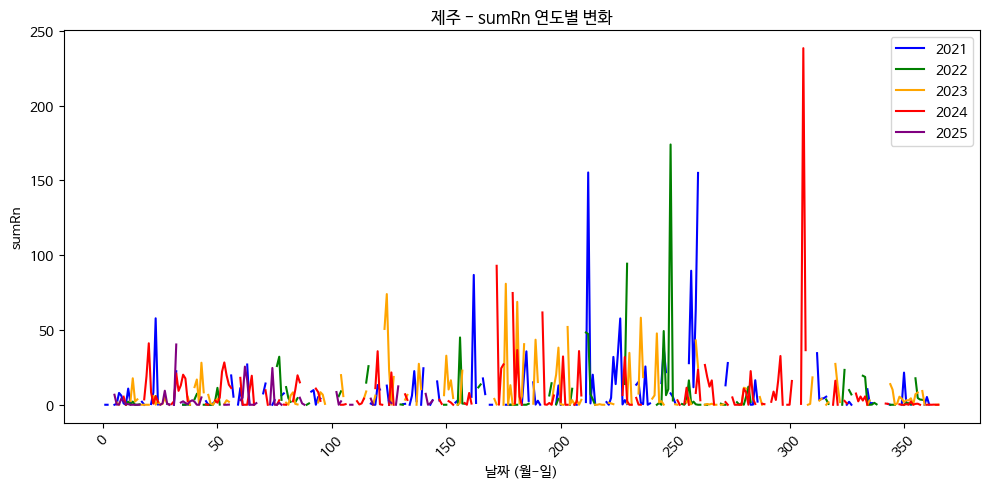

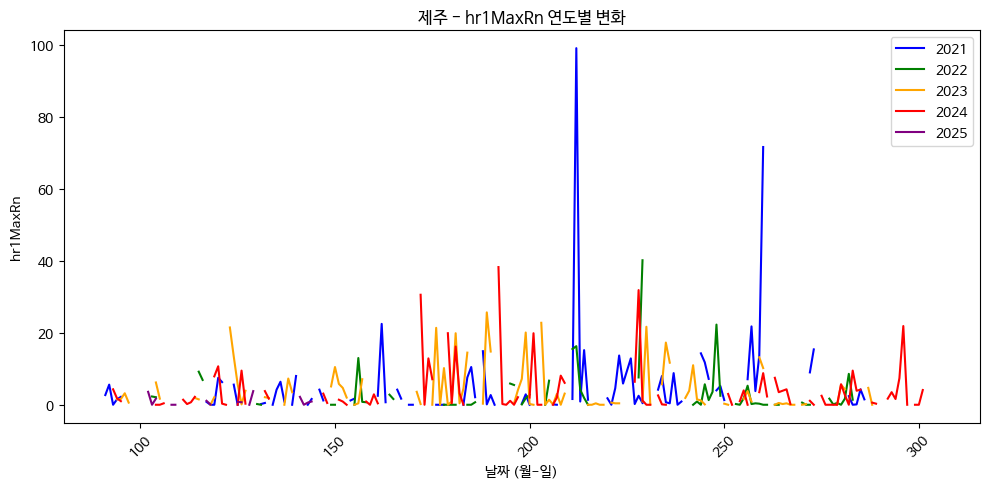

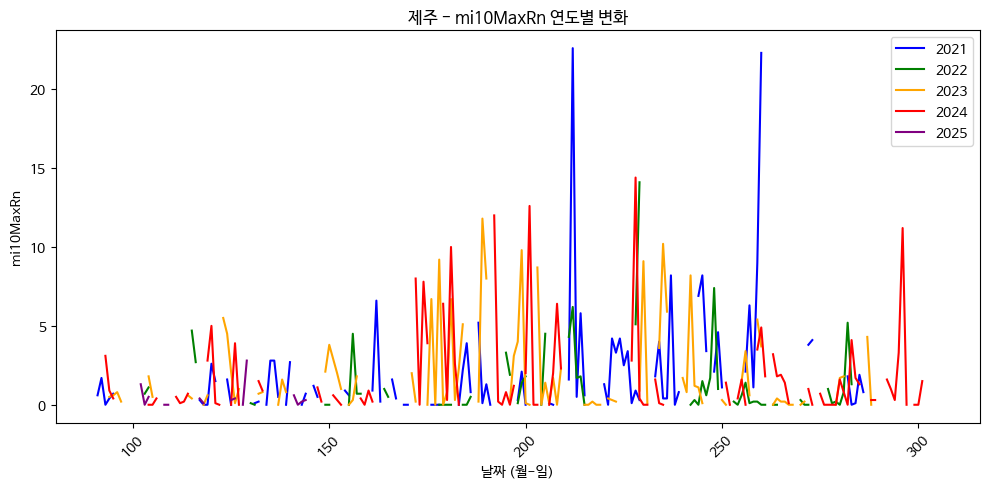

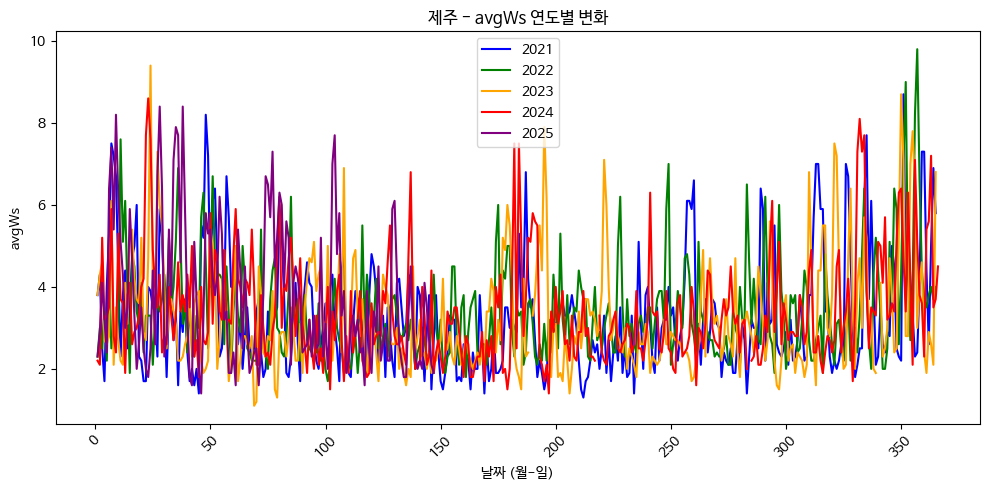

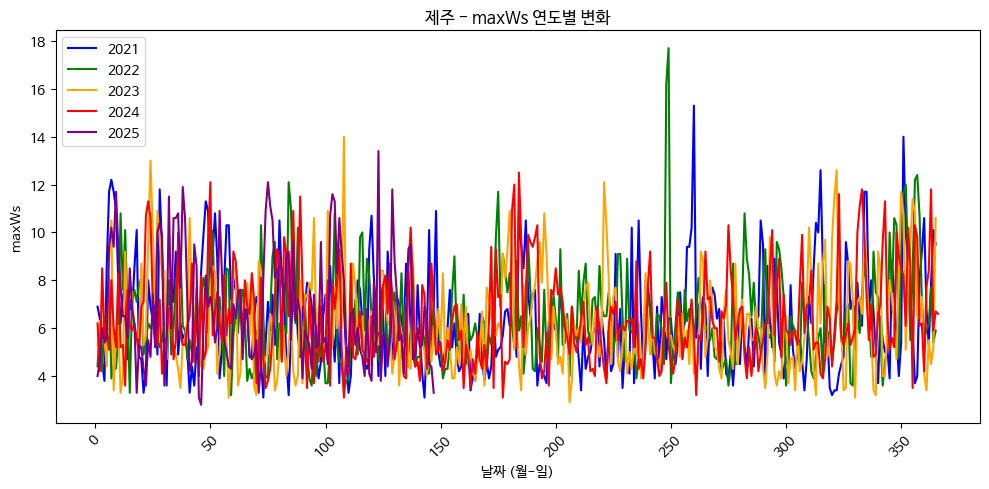

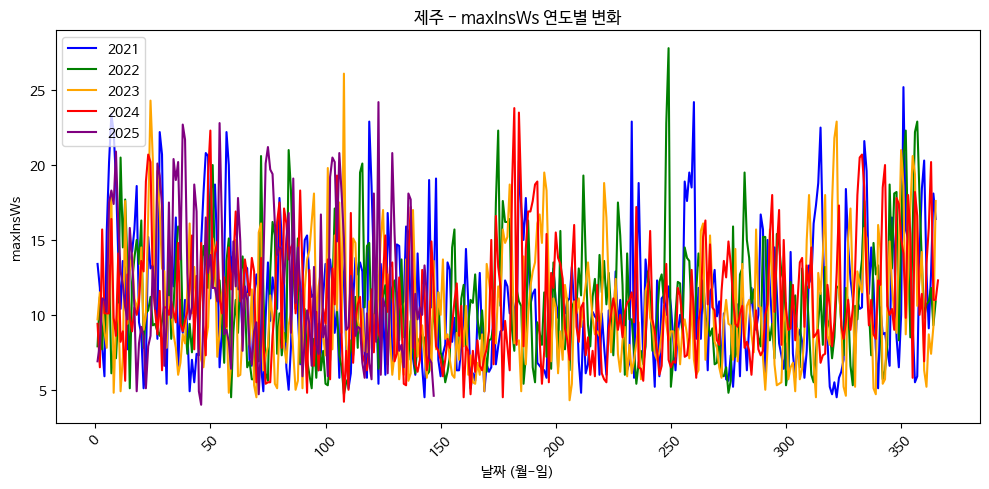

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === 설정 ===
# 사용할 변수
variables = ['avgTa', 'minTa', 'maxTa', 'sumRn', 'hr1MaxRn', 'mi10MaxRn', 'avgWs', 'maxWs', 'maxInsWs']

# 대표 지점 2곳 (예시: 서울 108, 제주 184)
representative_stations = {
    108: '서울',
    184: '제주'
}

# 연도별 색상 (명확히 구분되도록 설정)
year_colors = {
    "2021": "blue",
    "2022": "green",
    "2023": "orange",
    "2024": "red",
    "2025": "purple"
}

# === 데이터 불러오기 ===
df = pd.read_csv("../src/data/raw_weather_all_stations_2021_2025_selected_features.csv", parse_dates=["tm"])

# 연도 컬럼 추가
df["year"] = df["tm"].dt.year

# === 시각화 ===
for stn_id, stn_name in representative_stations.items():
    df_station = df[df["stnId"] == stn_id]

    for var in variables:
        plt.figure(figsize=(10, 5))

        for year, color in year_colors.items():
            df_year = df_station[df_station["year"] == int(year)]

            # 월-일만 추출해 비교용 x축 생성 (연도는 제거, 누적 패턴 보기 위해)
            df_year = df_year.copy()
            df_year["day"] = df_year["tm"].dt.dayofyear
            df_year = df_year.sort_values("day")
            
            plt.plot(df_year["day"], df_year[var], label=year, color=color)

        plt.title(f"{stn_name} - {var} 연도별 변화")
        plt.xlabel("날짜 (월-일)")
        plt.ylabel(var)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        ## 파일 저장
        # filename = f"{stn_name}_{var}_연도별_변화.png"
        # plt.savefig(filename)
        plt.close()


2025년은 5월까지의 데이터만 존재하기에 연도 간 MSE가 인위적으로 낮아지거나 높아진 경향이 보임

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from IPython.display import display

# 연도 리스트
years = list(map(int, year_colors.keys()))

# 결과 저장
similarity_results = []

# 각 지점, 각 변수에 대해 연도쌍 간 MSE 계산
for stn_id, stn_name in representative_stations.items():
    df_station = df[df["stnId"] == stn_id].copy()
    df_station["day"] = df_station["tm"].dt.dayofyear

    for var in variables:
        # 피벗: day 기준, year 별 value
        pivot = df_station.pivot_table(index="day", columns="year", values=var)

        # y1 고정, y2는 y1을 제외한 나머지 연도 전부
        for y1 in years:
            for y2 in years:
                if y1 == y2:
                    continue  # 같은 연도 비교는 제외

                # 공통 날짜만 비교
                if y1 in pivot.columns and y2 in pivot.columns:
                    valid = pivot[[y1, y2]].dropna()
                    if not valid.empty:
                        mse = mean_squared_error(valid[y1], valid[y2])
                        similarity_results.append({
                            "지점": stn_name,
                            "변수": var,
                            "연도1": y1,
                            "연도2": y2,
                            "MSE": mse
                        })

# DataFrame으로 정리
similarity_df = pd.DataFrame(similarity_results)

# 정렬: 지점-변수 그룹화 후, 연도1-연도2 기준 오름차순 정렬
sorted_df = similarity_df.sort_values(by=["지점", "변수", "연도1", "연도2"])

# CSV 저장
sorted_df.to_csv("../src/data/연도별_유사도_비교결과.csv", index=False)


2021년도와 2025년도의 데이터만 비교

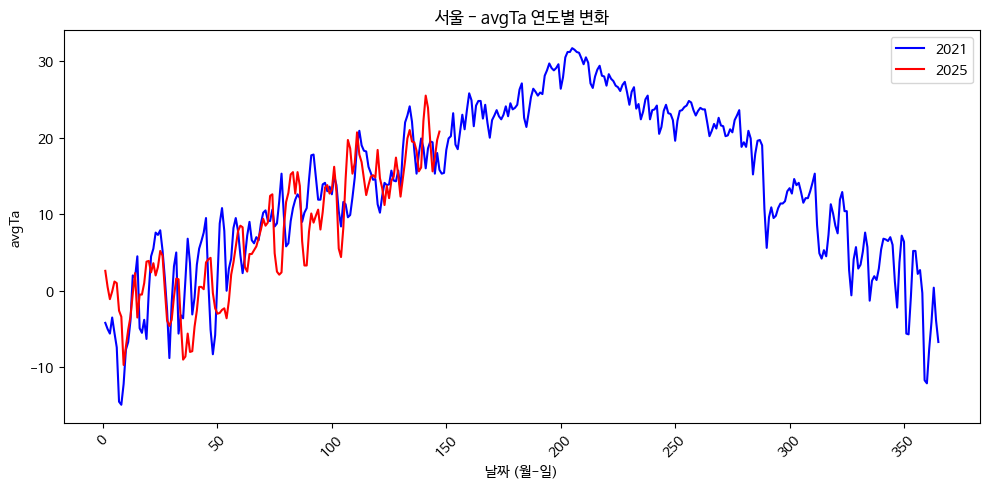

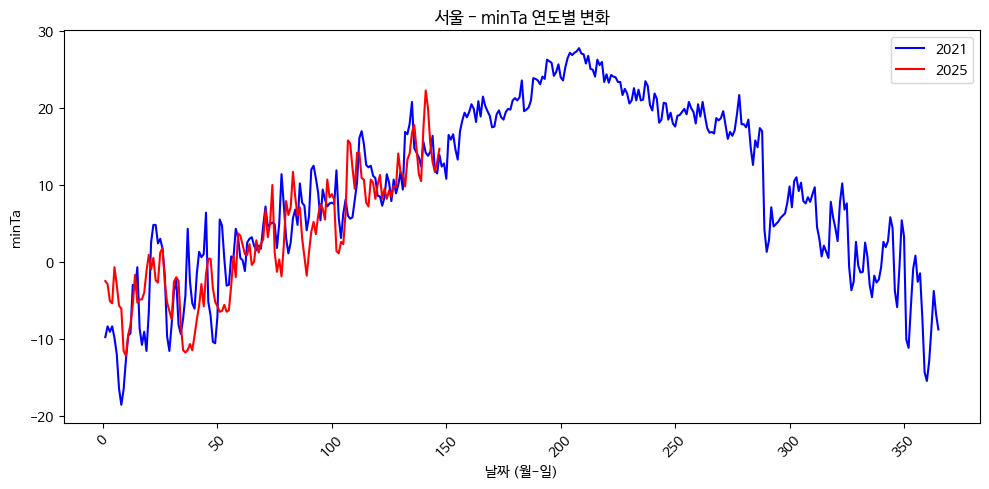

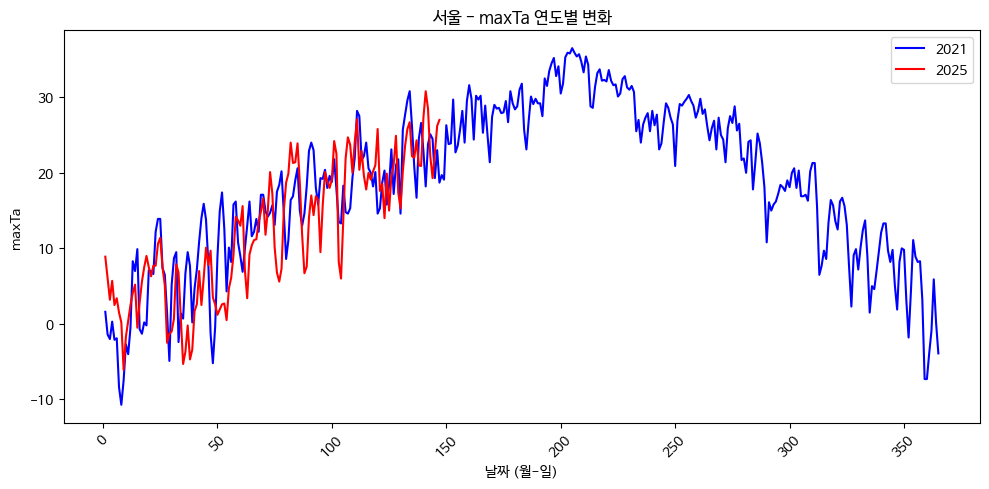

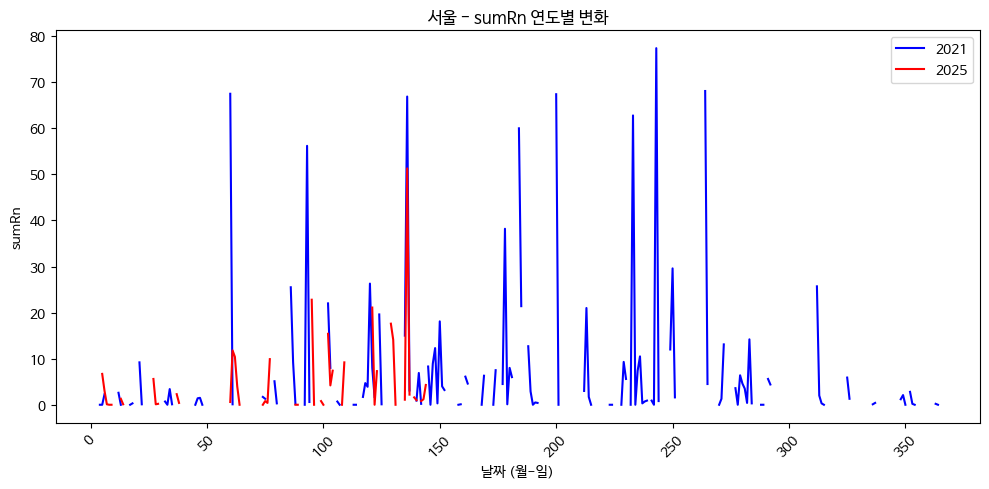

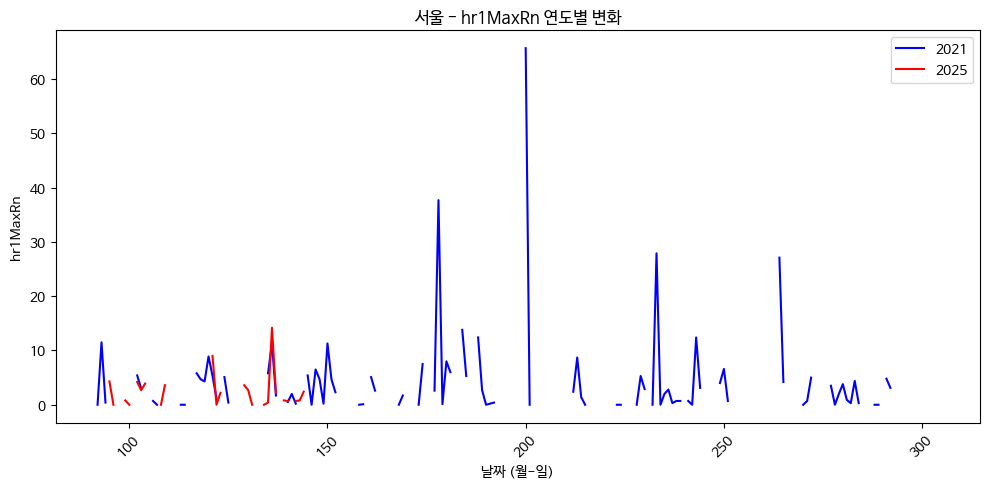

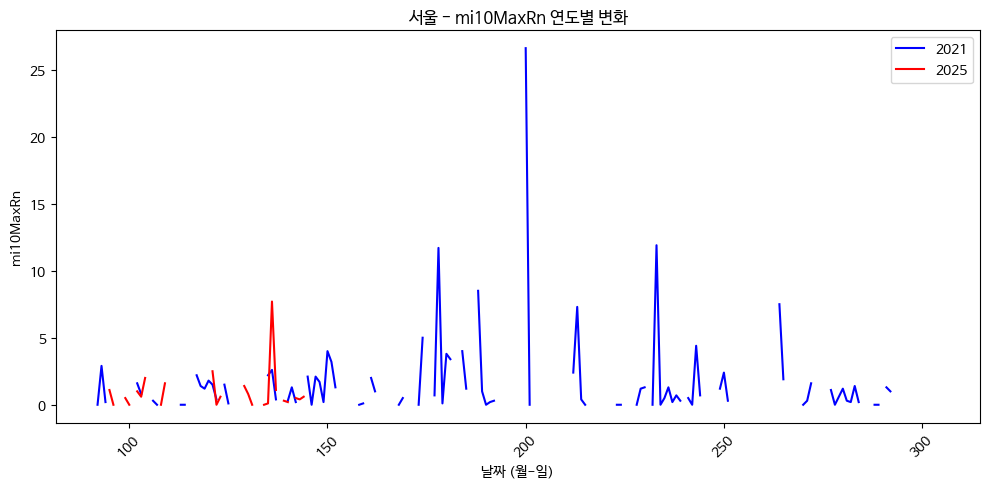

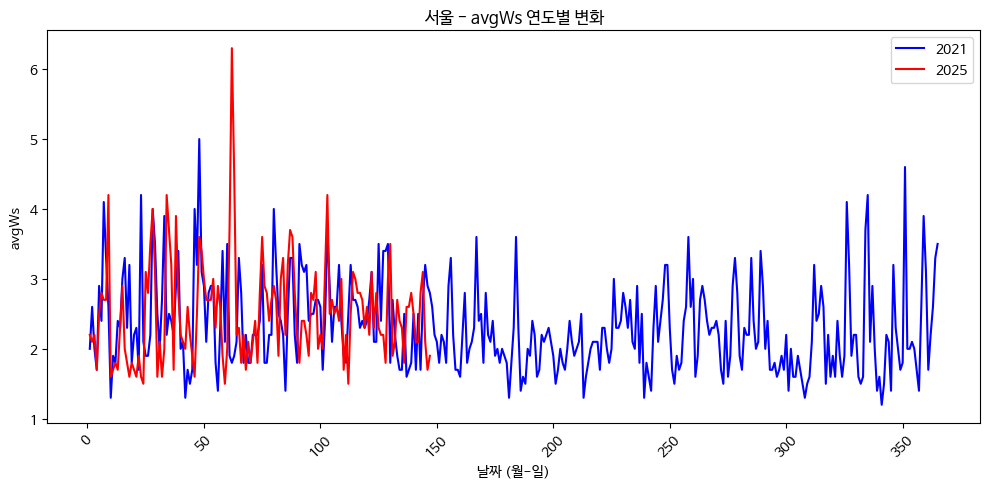

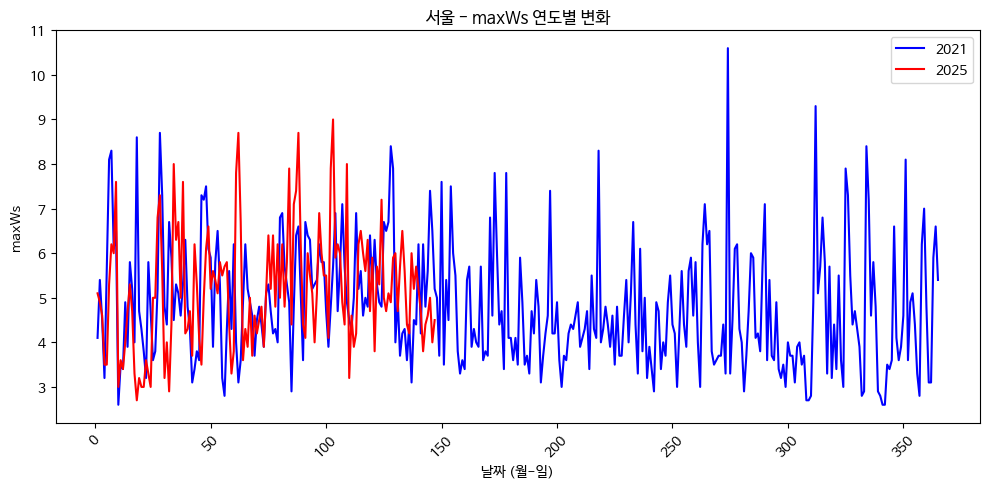

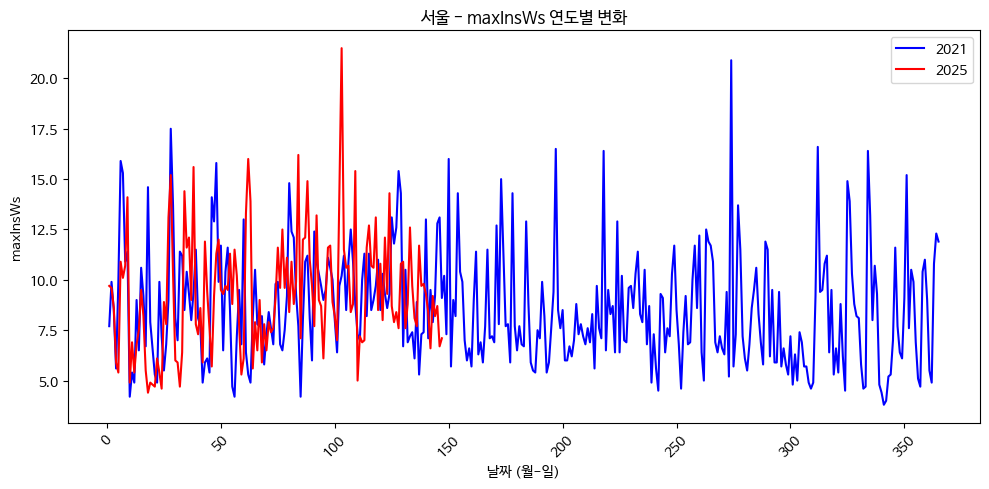

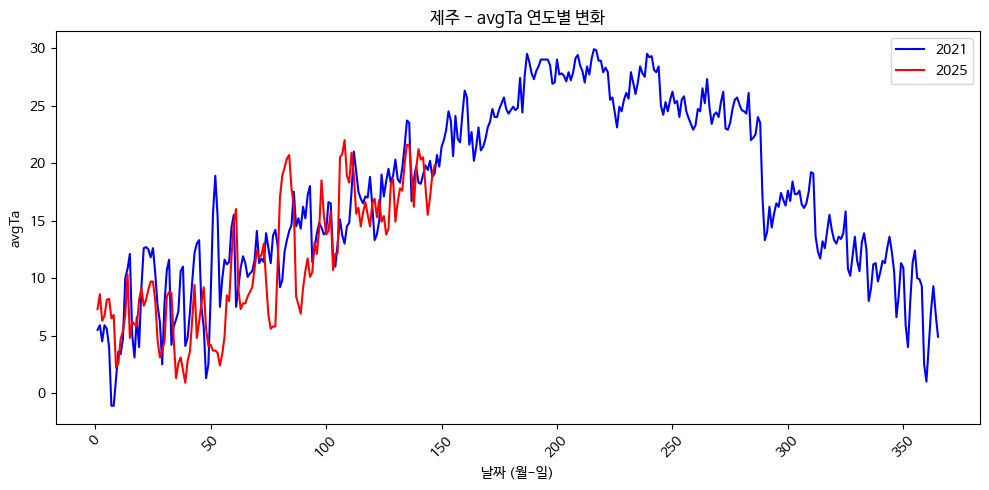

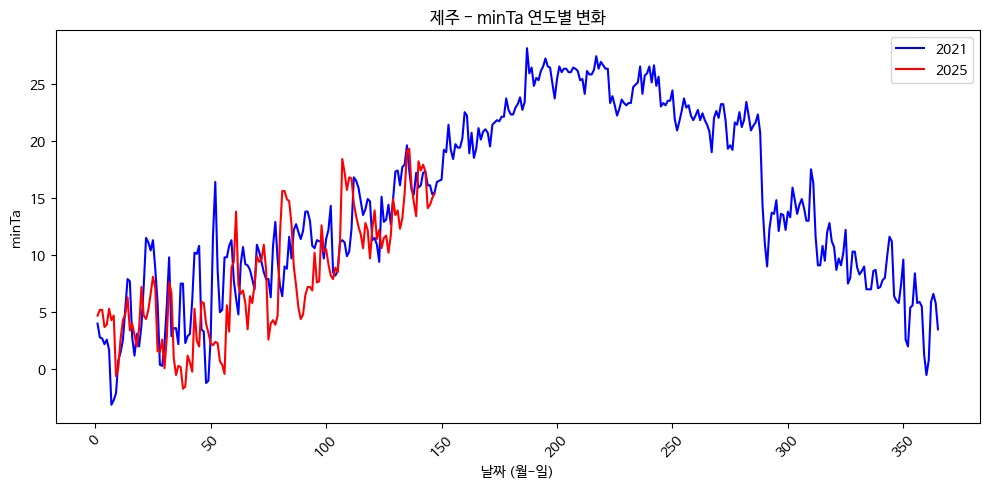

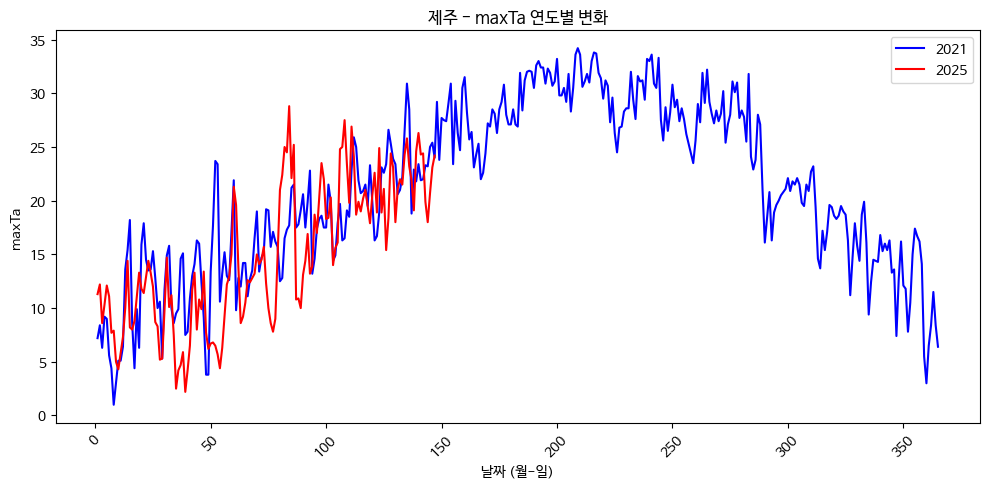

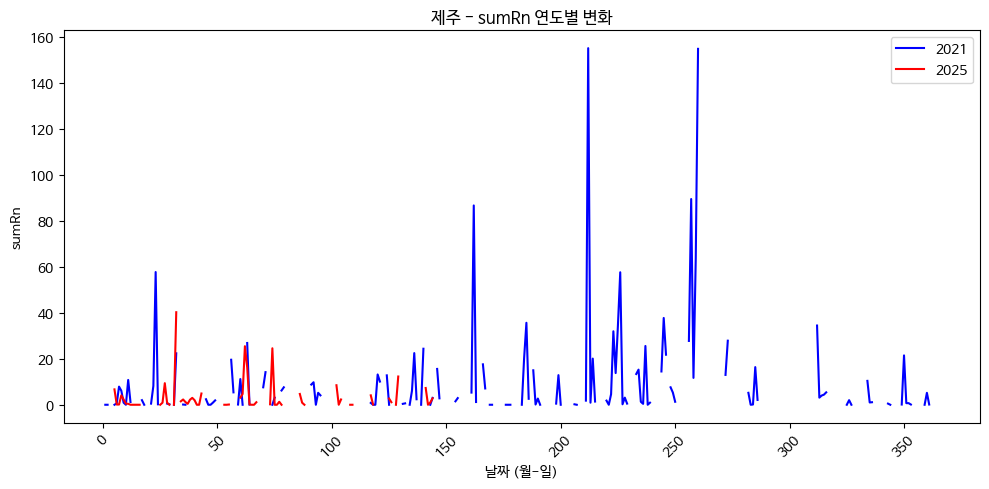

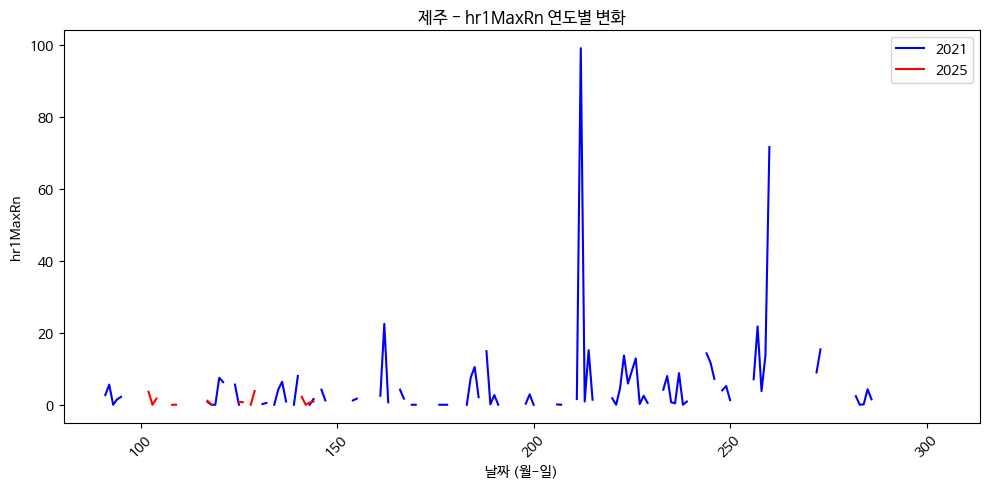

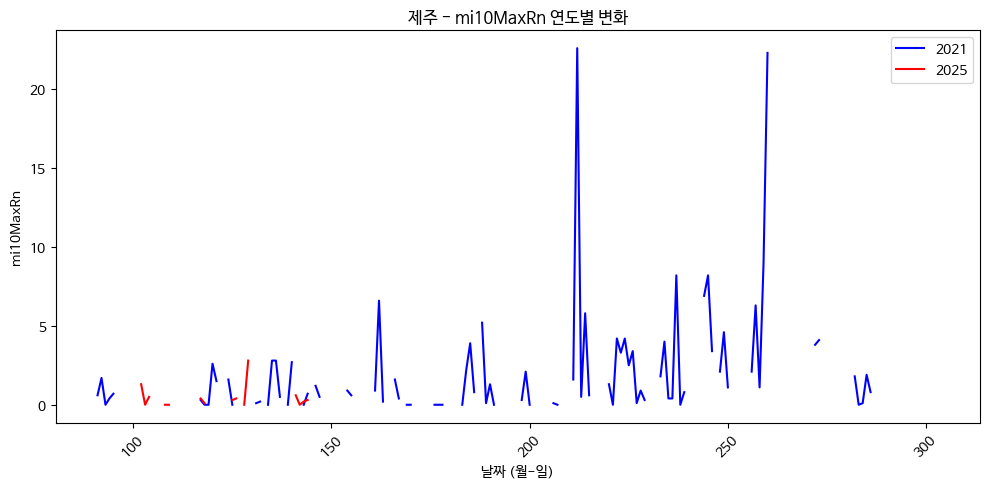

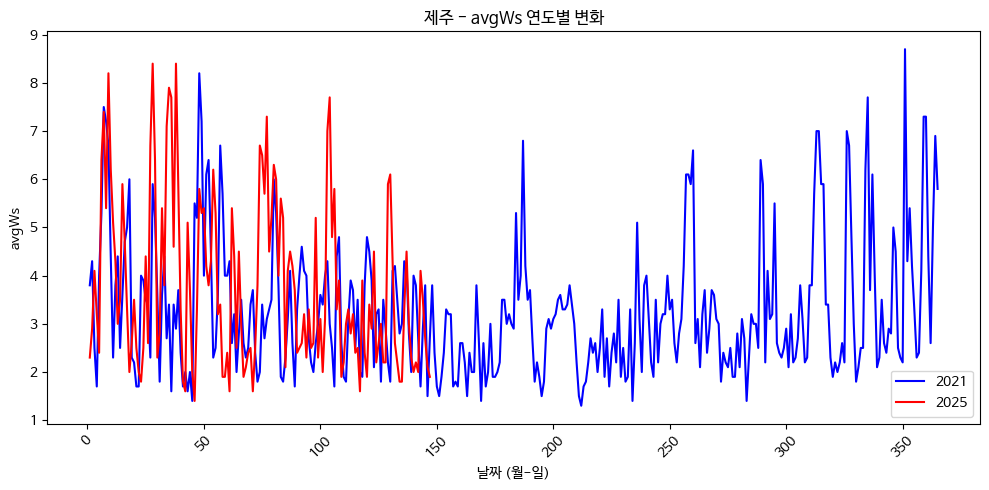

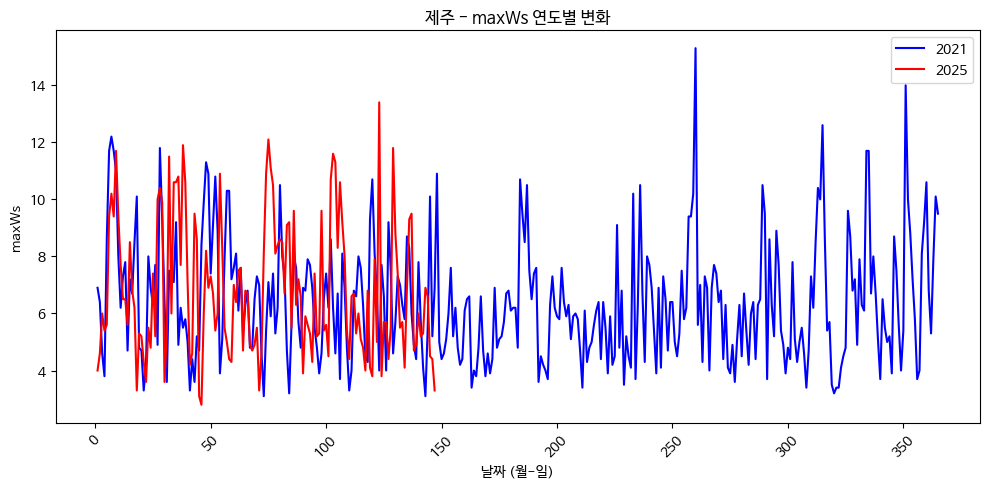

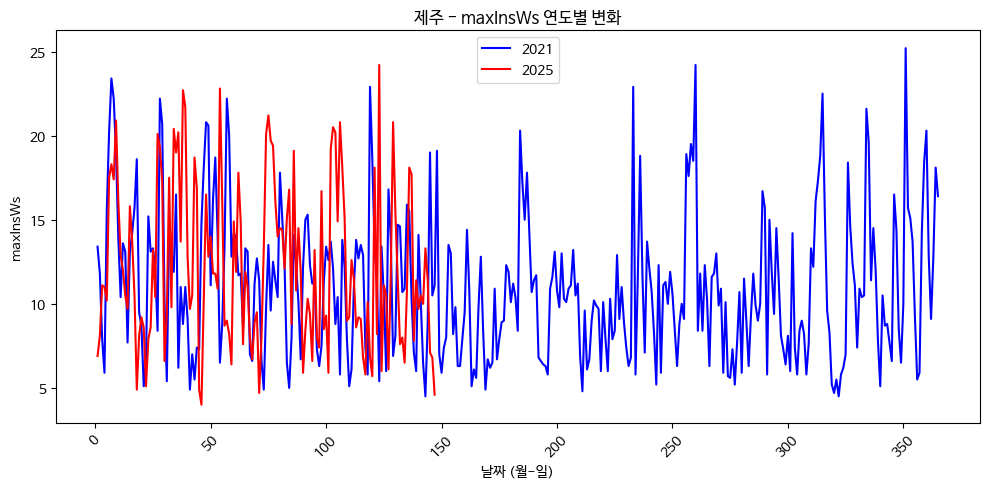

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === 설정 ===
# 사용할 변수
variables = ['avgTa', 'minTa', 'maxTa', 'sumRn', 'hr1MaxRn', 'mi10MaxRn', 'avgWs', 'maxWs', 'maxInsWs']

# 대표 지점 2곳 (예시: 서울 108, 제주 184)
representative_stations = {
    108: '서울',
    184: '제주'
}

# 연도별 색상 (명확히 구분되도록 설정)
year_colors = {
    "2021": "blue",
    "2025": "red"
}

# === 데이터 불러오기 ===
df = pd.read_csv("../src/data/raw_weather_all_stations_2021_2025_selected_features.csv", parse_dates=["tm"])

# 연도 컬럼 추가
df["year"] = df["tm"].dt.year

# === 시각화 ===
for stn_id, stn_name in representative_stations.items():
    df_station = df[df["stnId"] == stn_id]

    for var in variables:
        plt.figure(figsize=(10, 5))

        for year, color in year_colors.items():
            df_year = df_station[df_station["year"] == int(year)]

            # 월-일만 추출해 비교용 x축 생성 (연도는 제거, 누적 패턴 보기 위해)
            df_year = df_year.copy()
            df_year["day"] = df_year["tm"].dt.dayofyear
            df_year = df_year.sort_values("day")
            
            plt.plot(df_year["day"], df_year[var], label=year, color=color)

        plt.title(f"{stn_name} - {var} 연도별 변화")
        plt.xlabel("날짜 (월-일)")
        plt.ylabel(var)
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        ## 파일 저장
        # filename = f"{stn_name}_{var}_연도별_변화.png"
        # plt.savefig(filename)
        plt.close()


# 결측치 보간

In [ ]:
def fill_single_column_grouped(df, col, group_col='stnId'):
    for stn_id, df_group in tqdm(df.groupby(group_col), desc=f"📊 변수 {col} 처리 중"):
        df_group = df_group.sort_values('tm').reset_index()
        n = len(df_group)

        # 앞쪽 결측 처리
        first_valid_idx = df_group[col].first_valid_index()
        if first_valid_idx is not None and first_valid_idx > 0:
            df_group.loc[0:first_valid_idx - 1, col] = df_group.loc[first_valid_idx, col]

        # 뒤쪽 결측 처리
        last_valid_idx = df_group[col].last_valid_index()
        if last_valid_idx is not None and last_valid_idx < len(df_group) - 1:
            df_group.loc[last_valid_idx + 1:, col] = df_group.loc[last_valid_idx, col]

        # 중간 결측 보간
        isna = df_group[col].isna()
        i = 0
        while i < n:
            if isna.iloc[i]:
                start = i
                while i < n and isna.iloc[i]:
                    i += 1
                end = i - 1

                if start > 0 and end + 1 < n:
                    prev_val = df_group.loc[start - 1, col]
                    next_val = df_group.loc[end + 1, col]
                    if not pd.isna(prev_val) and not pd.isna(next_val):
                        df_group.loc[start:end, col] = ((prev_val + next_val) / 2).round(1)
            else:
                i += 1

        # 결과 반영
        df.loc[df_group['index'], col] = df_group[col].values

    return df

In [9]:
interpolate_cols = ['avgTa', 'minTa', 'maxTa', 'avgWs', 'maxWs', 'maxInsWs']
fillzero_cols = ['sumRn', 'hr1MaxRn', 'mi10MaxRn']

df = pd.read_csv("../src/data/raw_weather_all_stations_2021_2025_selected_features.csv")

# 변수별로 독립적으로 보간 수행
for col in interpolate_cols:
    df = fill_single_column_grouped(df, col)

# 나머지는 0으로 채움
df[fillzero_cols] = df[fillzero_cols].fillna(0)


📊 변수 maxInsWs 처리 중: 100%|██████████| 95/95 [00:01<00:00, 84.56it/s]


In [10]:
df.to_csv('check.csv')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152845 entries, 0 to 152844
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   stnId      152845 non-null  int64  
 1   stnNm      152845 non-null  object 
 2   tm         152845 non-null  object 
 3   avgTa      152845 non-null  float64
 4   minTa      152845 non-null  float64
 5   maxTa      152845 non-null  float64
 6   sumRn      152845 non-null  float64
 7   hr1MaxRn   152845 non-null  float64
 8   mi10MaxRn  152845 non-null  float64
 9   avgWs      152845 non-null  float64
 10  maxWs      152845 non-null  float64
 11  maxInsWs   152845 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 14.0+ MB
